In [49]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import aqi as aqi
import joblib

In [50]:
# Read all individual 2019 data files per each quarter
df_2019_Q1 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2019Q1.csv')
df_2019_Q2 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2019Q2.csv')
df_2019_Q3 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2019Q3.csv')
df_2019_Q4 = pd.read_csv('/Users/nkichili/Desktop/Synopsys/waqi-covid19-airqualitydata-2019Q4.csv')

In [51]:
# This current analysis considers only USA as other countries in the data set don't have required pollutant attributes
# USA data set doesn't come up with AQI (Air Quality Index) which needs to be calculated later (mentioned below)
df_2019_Q1_USA = df_2019_Q1.loc[df_2019_Q1['Country'] == 'US']
df_2019_Q2_USA = df_2019_Q2.loc[df_2019_Q2['Country'] == 'US']
df_2019_Q3_USA = df_2019_Q3.loc[df_2019_Q3['Country'] == 'US']
df_2019_Q4_USA = df_2019_Q4.loc[df_2019_Q4['Country'] == 'US']

In [52]:
# Choose only the required columns as we don't need count (samples), min, max, variance. 
cols = ['Date','Country','City','Specie','median']
df_2019_Q1_USA_5 = df_2019_Q1_USA[cols]
df_2019_Q2_USA_5 = df_2019_Q2_USA[cols]
df_2019_Q3_USA_5 = df_2019_Q3_USA[cols]
df_2019_Q4_USA_5 = df_2019_Q4_USA[cols]

In [53]:
# The original data set contains each pollutant by date, city, country in each row which is hard to perform analysis
# Use Pivot to transponse long to wide format so that each row will have Date, Country, City, other polluntant attributes, value
df_2019_Q1_USA_PV = df_2019_Q1_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2019_Q2_USA_PV = df_2019_Q2_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2019_Q3_USA_PV = df_2019_Q3_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()
df_2019_Q4_USA_PV = df_2019_Q4_USA_5.pivot(index=['Date','Country','City'], columns='Specie', values='median').reset_index()

In [54]:
# A sample of columns listed below based on the above step execution
df_2019_Q1_USA_PV.columns

Index(['Date', 'Country', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10',
       'pm25', 'precipitation', 'pressure', 'so2', 'temperature', 'wd',
       'wind-gust', 'wind-speed'],
      dtype='object', name='Specie')

In [55]:
# Air Quality Index (AQI) requires one of pm10 or pm25 and at least total 3 attributes from CO, NO2, O3, PM10, PM25, SO2
# Reference: https://app.cpcbccr.com/ccr_docs/How_AQI_Calculated.pdf
# Refer page#14 in https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf

df_2019_Q1_USA_POLLUTANT = df_2019_Q1_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2019_Q2_USA_POLLUTANT = df_2019_Q2_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2019_Q3_USA_POLLUTANT = df_2019_Q3_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]
df_2019_Q4_USA_POLLUTANT = df_2019_Q4_USA_PV[['Date','Country','City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2']]

In [56]:
# Combine all quarters of 2019 data set
df_2019_USA_FINAL = df_2019_Q1_USA_POLLUTANT.append([df_2019_Q2_USA_POLLUTANT, df_2019_Q3_USA_POLLUTANT, df_2019_Q4_USA_POLLUTANT])
df_2019_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21468 entries, 0 to 5547
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     21468 non-null  object 
 1   Country  21468 non-null  object 
 2   City     21468 non-null  object 
 3   co       14683 non-null  float64
 4   no2      14248 non-null  float64
 5   o3       20395 non-null  float64
 6   pm10     9400 non-null   float64
 7   pm25     21081 non-null  float64
 8   so2      8318 non-null   float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


In [57]:
# The above info shows that there are lot of missing values for pollutants (Eg: Out of 21468 entries, pm25 has values for 21081 only)
df_2019_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2018-12-31,US,Albuquerque,3.0,16.7,16.8,21.0,40.0,1.5
1,2018-12-31,US,Atlanta,1.8,2.8,15.2,12.0,27.0,NaN
2,2018-12-31,US,Austin,NaN,NaN,4.0,NaN,21.0,NaN
3,2018-12-31,US,Baltimore,NaN,13.0,12.8,21.0,50.0,NaN
4,2018-12-31,US,Boise,4.5,NaN,24.9,7.0,9.0,0.8


<AxesSubplot:xlabel='Specie'>

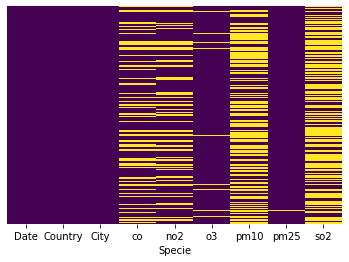

In [58]:
# The below heatmap shows missing values (yellow color) for different pollutants
sns.heatmap(df_2019_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [59]:
# Fill the missing values of pollutants by taking mean of that pollutant for that country and city
df_2019_USA_FINAL['pm10'] = df_2019_USA_FINAL.groupby(["Country", "City"])['pm10'].transform(lambda x: x.fillna(x.mean()))
df_2019_USA_FINAL['pm25'] = df_2019_USA_FINAL.groupby(["Country", "City"])['pm25'].transform(lambda x: x.fillna(x.mean()))
df_2019_USA_FINAL['no2'] = df_2019_USA_FINAL.groupby(["Country", "City"])['no2'].transform(lambda x: x.fillna(x.mean()))
df_2019_USA_FINAL['so2'] = df_2019_USA_FINAL.groupby(["Country", "City"])['so2'].transform(lambda x: x.fillna(x.mean()))
df_2019_USA_FINAL['co'] = df_2019_USA_FINAL.groupby(["Country", "City"])['co'].transform(lambda x: x.fillna(x.mean()))
df_2019_USA_FINAL['o3'] = df_2019_USA_FINAL.groupby(["Country", "City"])['o3'].transform(lambda x: x.fillna(x.mean()))


In [60]:
df_2019_USA_FINAL.columns

Index(['Date', 'Country', 'City', 'co', 'no2', 'o3', 'pm10', 'pm25', 'so2'], dtype='object', name='Specie')

<AxesSubplot:xlabel='Specie'>

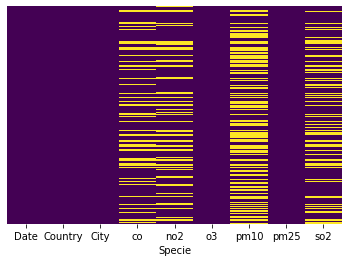

In [61]:
# After filling the missing values with mean of the specific pollutant as stated above, this heatmap still shows some missing values
sns.heatmap(df_2019_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [62]:
#Before applying mean for missing values, so2 had values for 8318 entries only but after applying mean, so2 has values for 14672
df_2019_USA_FINAL.info()
df_2019_USA_FINAL.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21468 entries, 0 to 5547
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     21468 non-null  object 
 1   Country  21468 non-null  object 
 2   City     21468 non-null  object 
 3   co       15830 non-null  float64
 4   no2      15074 non-null  float64
 5   o3       21468 non-null  float64
 6   pm10     10571 non-null  float64
 7   pm25     21468 non-null  float64
 8   so2      14672 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2018-12-31,US,Albuquerque,3.0,16.700000,16.8,21.0,40.0,1.500000
1,2018-12-31,US,Atlanta,1.8,2.800000,15.2,12.0,27.0,1.364257
2,2018-12-31,US,Austin,NaN,NaN,4.0,NaN,21.0,NaN
3,2018-12-31,US,Baltimore,NaN,13.000000,12.8,21.0,50.0,1.964286
4,2018-12-31,US,Boise,4.5,10.080741,24.9,7.0,9.0,0.800000


In [63]:
# This time, fill the missing value of mean of a particular pollutant based on all rows of that column instead of restricting with specific cities
df_2019_USA_FINAL['pm10'] = df_2019_USA_FINAL['pm10'].fillna(df_2019_USA_FINAL['pm10'].mean())
df_2019_USA_FINAL['pm25'] = df_2019_USA_FINAL['pm25'].fillna(df_2019_USA_FINAL['pm25'].mean())
df_2019_USA_FINAL['no2'] = df_2019_USA_FINAL['no2'].fillna(df_2019_USA_FINAL['no2'].mean())
df_2019_USA_FINAL['so2'] = df_2019_USA_FINAL['so2'].fillna(df_2019_USA_FINAL['so2'].mean())
df_2019_USA_FINAL['co'] = df_2019_USA_FINAL['co'].fillna(df_2019_USA_FINAL['co'].mean())
df_2019_USA_FINAL['o3'] = df_2019_USA_FINAL['o3'].fillna(df_2019_USA_FINAL['o3'].mean())
df_2019_USA_FINAL

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2
0,2018-12-31,US,Albuquerque,3.000000,16.700000,16.8,21.000000,40.0,1.500000
1,2018-12-31,US,Atlanta,1.800000,2.800000,15.2,12.000000,27.0,1.364257
2,2018-12-31,US,Austin,5.713845,8.420395,4.0,16.576044,21.0,1.254280
3,2018-12-31,US,Baltimore,5.713845,13.000000,12.8,21.000000,50.0,1.964286
4,2018-12-31,US,Boise,4.500000,10.080741,24.9,7.000000,9.0,0.800000
...,...,...,...,...,...,...,...,...,...
5543,2020-01-05,US,Staten Island,2.200000,2.800000,22.4,16.576044,22.0,1.555556
5544,2020-01-05,US,Tallahassee,9.100000,8.420395,11.4,16.576044,20.0,0.600000
5545,2020-01-05,US,The Bronx,1.600000,6.100000,21.6,16.576044,29.0,1.254280
5546,2020-01-05,US,Tucson,2.700000,12.700000,15.2,17.000000,34.0,0.300000


<AxesSubplot:xlabel='Specie'>

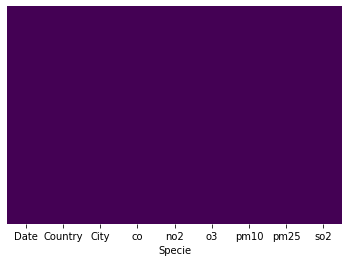

In [64]:
# WIth the above fill of missing values, now the heatmap doesn't show any yellow spots. So, there are no missing values in the data set now
sns.heatmap(df_2019_USA_FINAL.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [65]:
# This shows all pollutants have values as it matches total number of entries (21468)
df_2019_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21468 entries, 0 to 5547
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     21468 non-null  object 
 1   Country  21468 non-null  object 
 2   City     21468 non-null  object 
 3   co       21468 non-null  float64
 4   no2      21468 non-null  float64
 5   o3       21468 non-null  float64
 6   pm10     21468 non-null  float64
 7   pm25     21468 non-null  float64
 8   so2      21468 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


<AxesSubplot:xlabel='City'>

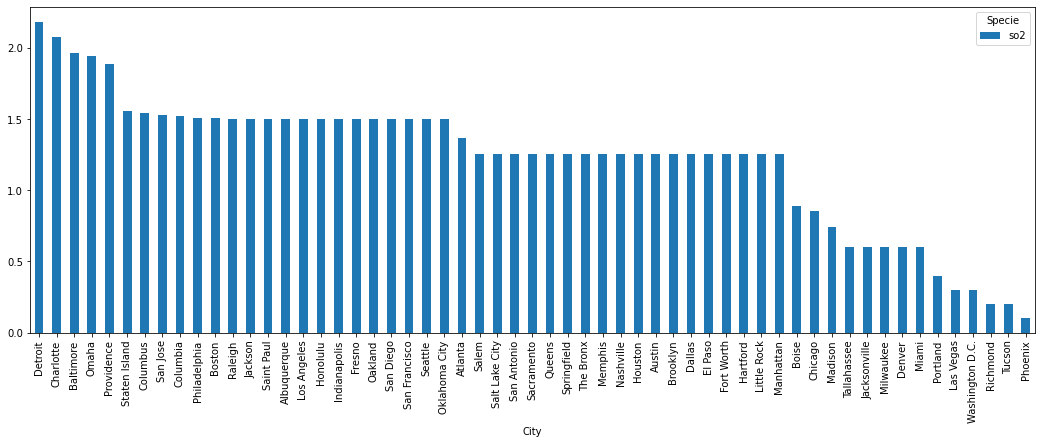

In [66]:
df_2019_USA_FINAL[['so2', 'City']].groupby(['City']).median().sort_values("so2", ascending = False).plot.bar(figsize=(18,6)
                                                                                                            )

<AxesSubplot:xlabel='City'>

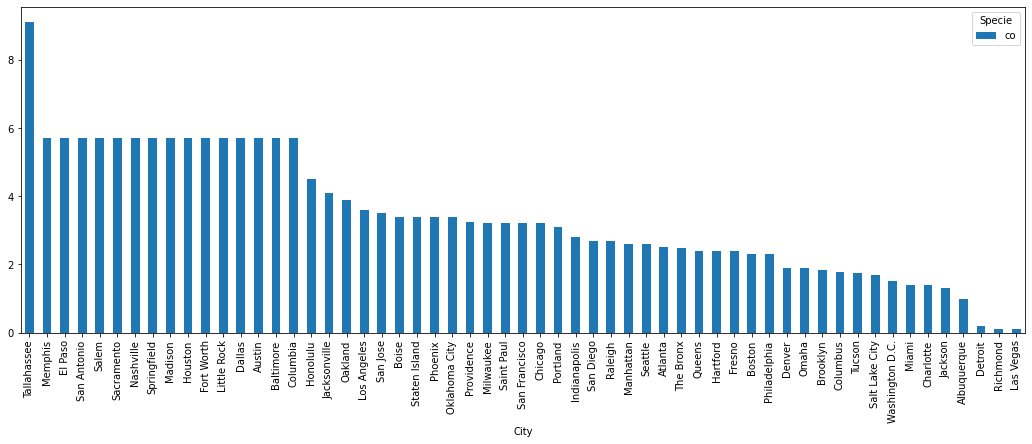

In [67]:
df_2019_USA_FINAL[['co', 'City']].groupby(['City']).median().sort_values("co", ascending = False).plot.bar(figsize=(18,6))


<AxesSubplot:xlabel='City'>

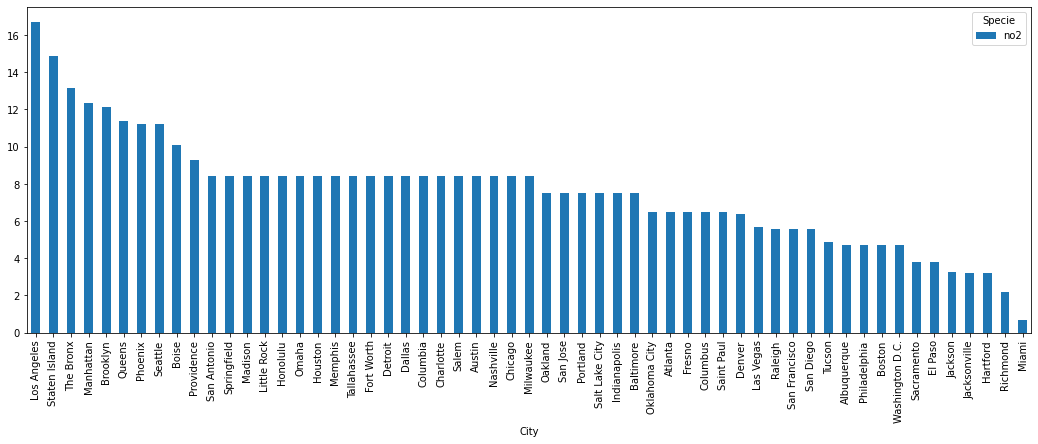

In [68]:
df_2019_USA_FINAL[['no2', 'City']].groupby(['City']).median().sort_values("no2", ascending = False).plot.bar(figsize=(18,6))


<AxesSubplot:xlabel='City'>

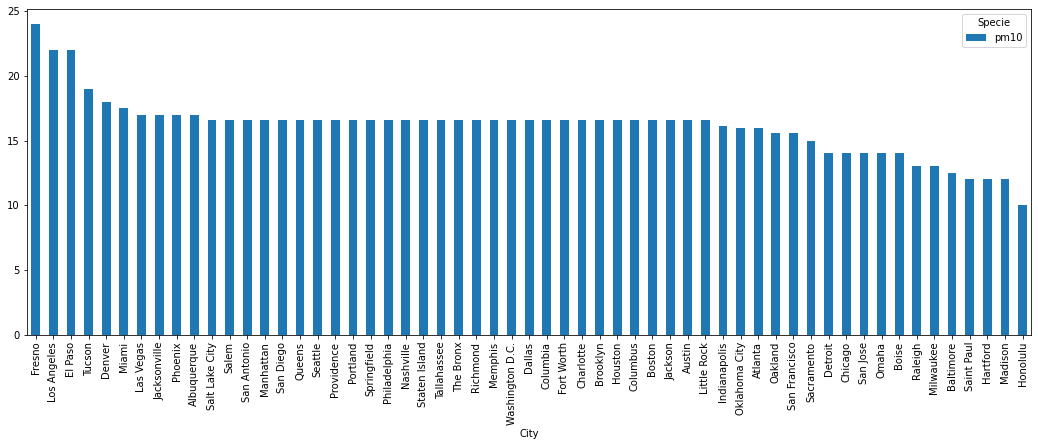

In [69]:
df_2019_USA_FINAL[['pm10', 'City']].groupby(['City']).median().sort_values("pm10", ascending = False).plot.bar(figsize=(18,6))


Distribution of different pollutants


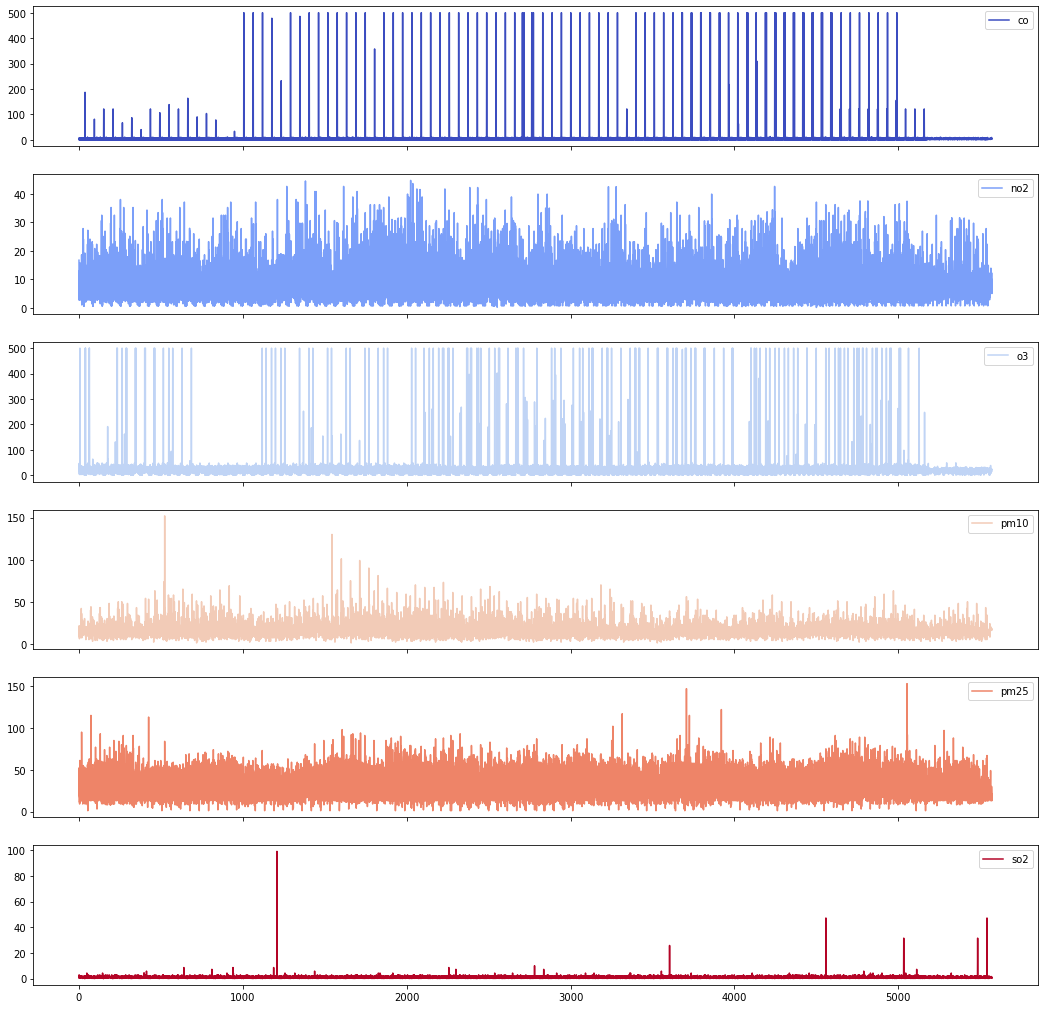

In [70]:
# This is just exploratory data analysis to plot pollutant in 2019
pollutants = ['co', 'no2', 'o3', 'pm10', 'pm25', 'so2']

df_2019_USA_FINAL_PLT = df_2019_USA_FINAL[pollutants]

print('Distribution of different pollutants')
df_2019_USA_FINAL_PLT.plot(kind='line',figsize=(18,18),cmap='coolwarm',subplots=True,fontsize=10);

<AxesSubplot:xlabel='Specie', ylabel='Specie'>

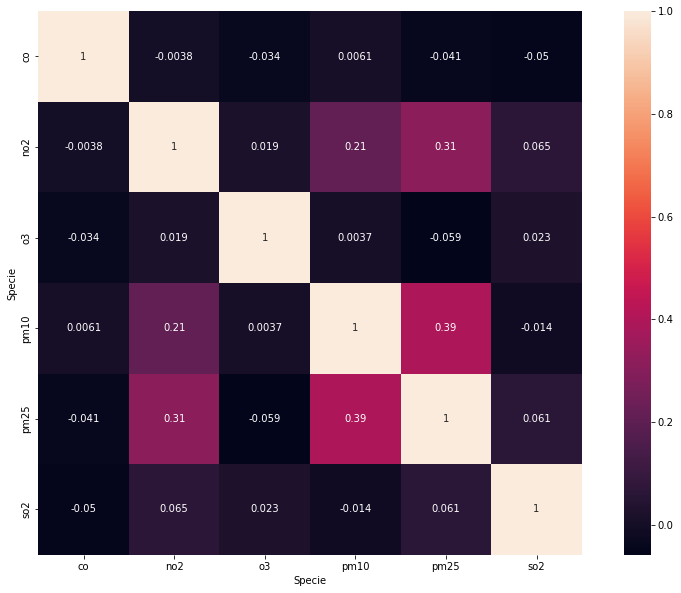

In [71]:
corrmat = df_2019_USA_FINAL[pollutants].corr()
f, ax = plt.subplots(figsize = (15, 10))
sns.heatmap(corrmat, vmax = 1, square = True, annot = True)

In [72]:
def top_and_bottom_10_states(indicator="so2"):
    fig, ax = plt.subplots(2,1, figsize=(20, 12))
    
    ind = df_2019_USA_FINAL[[indicator, 'City']].groupby('City', as_index=False).median().sort_values(by=indicator,ascending=False)
    top10 = sns.barplot(x='City', y=indicator, data=ind[:10], ax=ax[0])
    top10.set_title("Top 10 states by {} (2019)".format(indicator))
    top10.set_ylabel(indicator)
    top10.set_xlabel("City")
    
    bottom10 = sns.barplot(x='City', y=indicator, data=ind[-10:], ax=ax[1])
    bottom10.set_title("Bottom 10 states by {} (2019)".format(indicator))
    bottom10.set_ylabel(indicator)
    bottom10.set_xlabel("City")

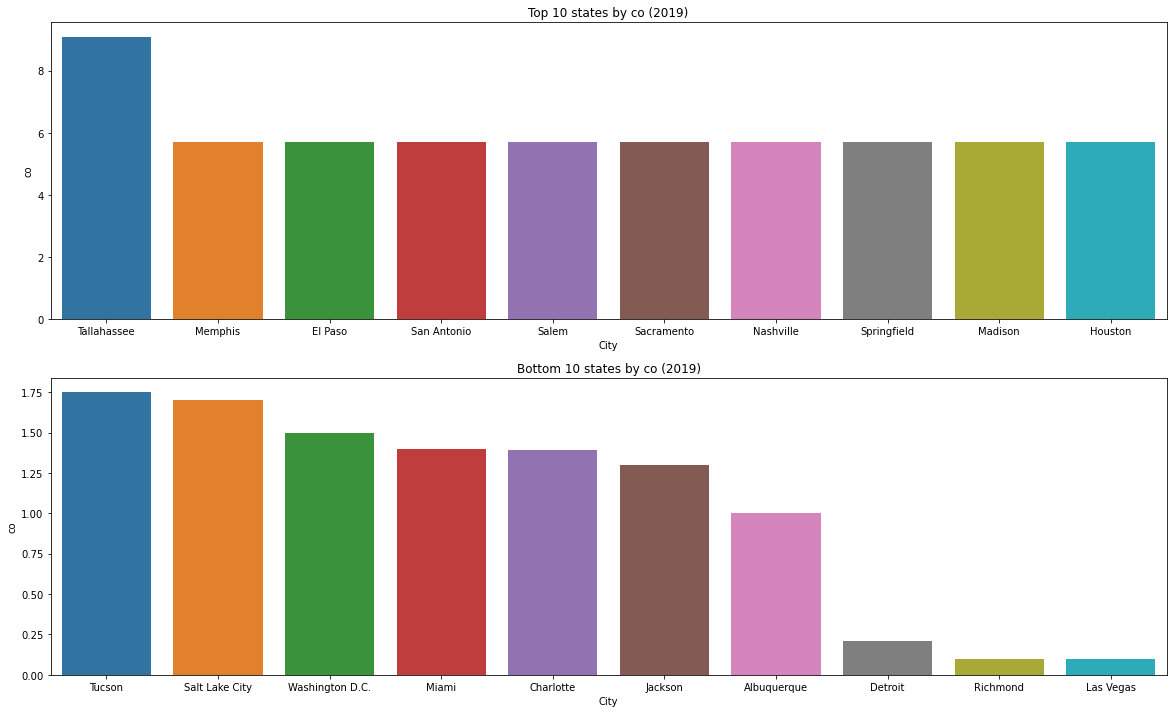

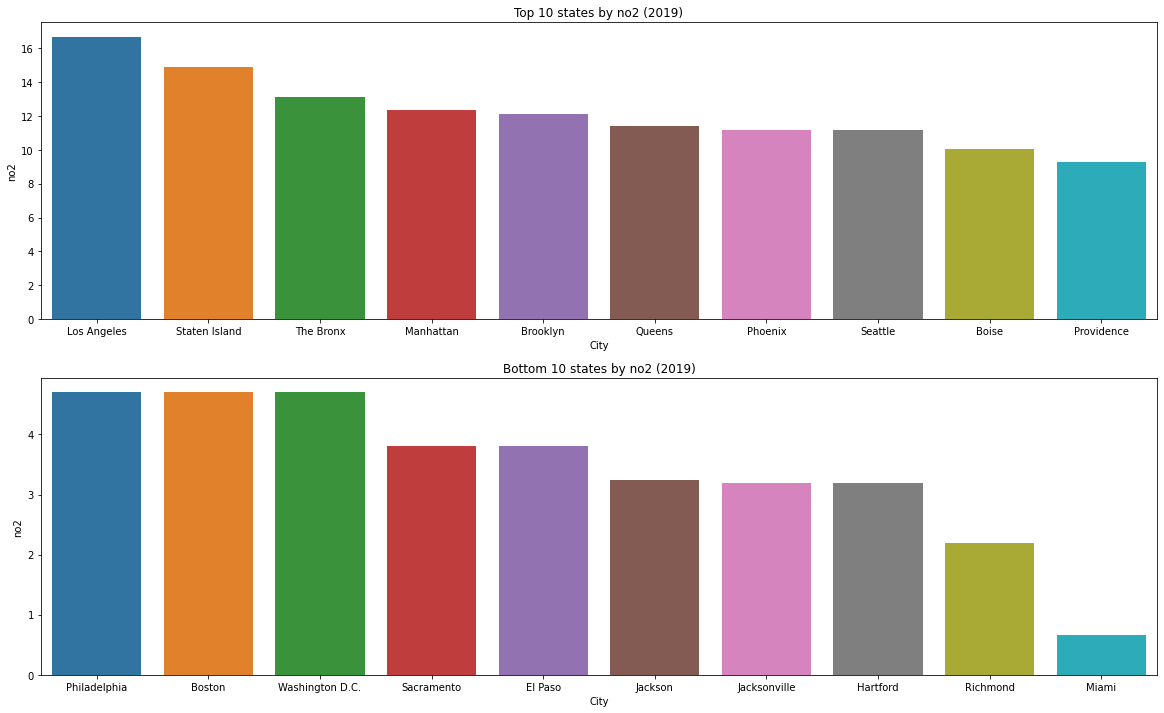

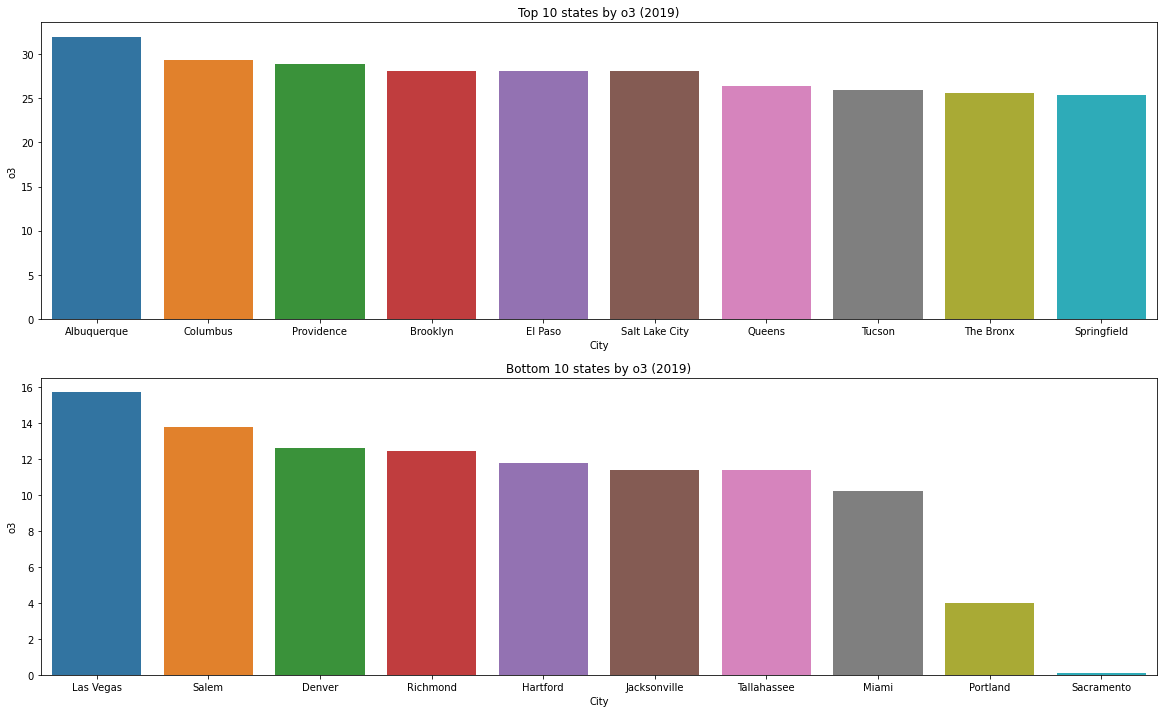

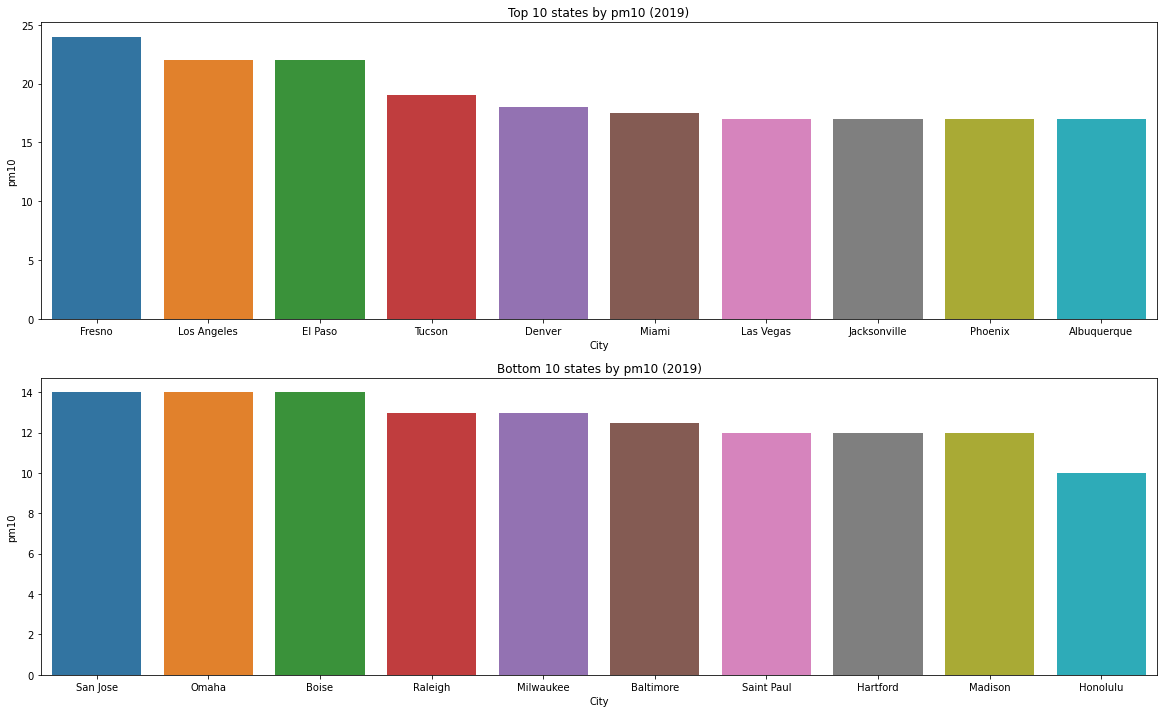

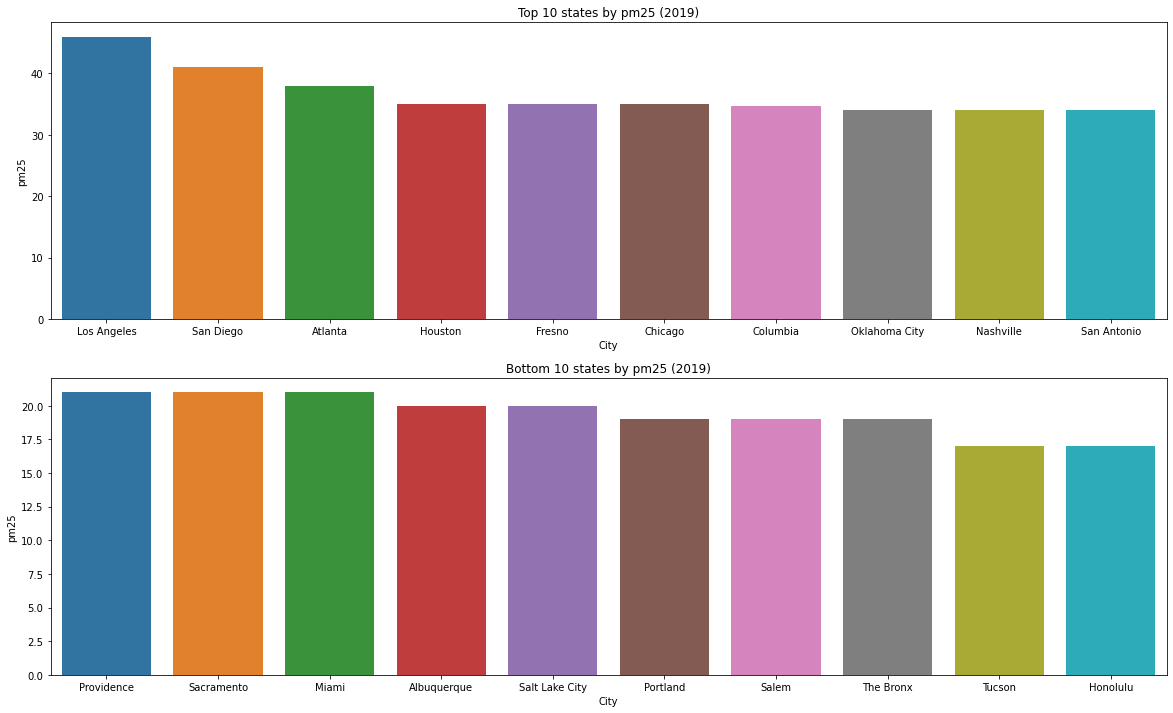

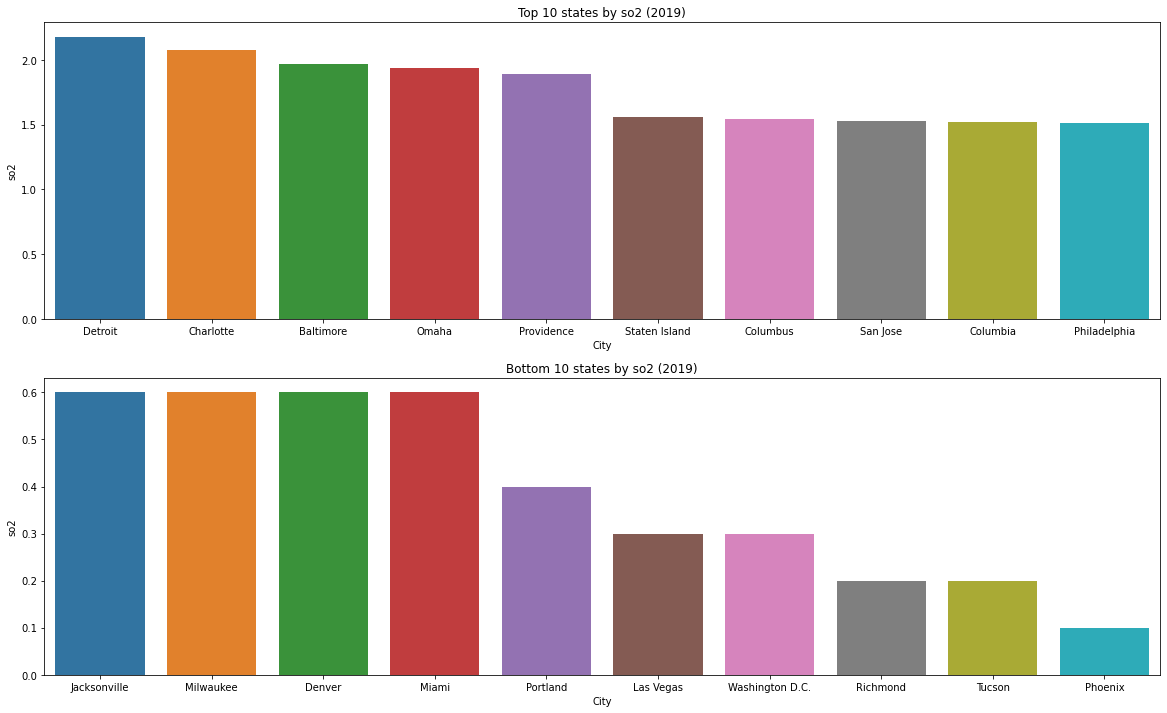

In [73]:
top_and_bottom_10_states("co")
top_and_bottom_10_states("no2")
top_and_bottom_10_states("o3")
top_and_bottom_10_states("pm10")
top_and_bottom_10_states("pm25")
top_and_bottom_10_states("so2")

In [74]:
# defining a function to find the highest ever recorded levels for a given indicator (defaults to SO2) by state
# sidenote: mostly outliers
def highest_levels_recorded(indicator="so2"):
    plt.figure(figsize=(20,10))
    ind = df_2019_USA_FINAL[[indicator, 'City', 'Date']].groupby('City', as_index=False).max()
    highest = sns.barplot(x='City', y=indicator, data=ind)
    highest.set_title("Highest ever {} levels recorded by City".format(indicator))
    plt.xticks(rotation=90)

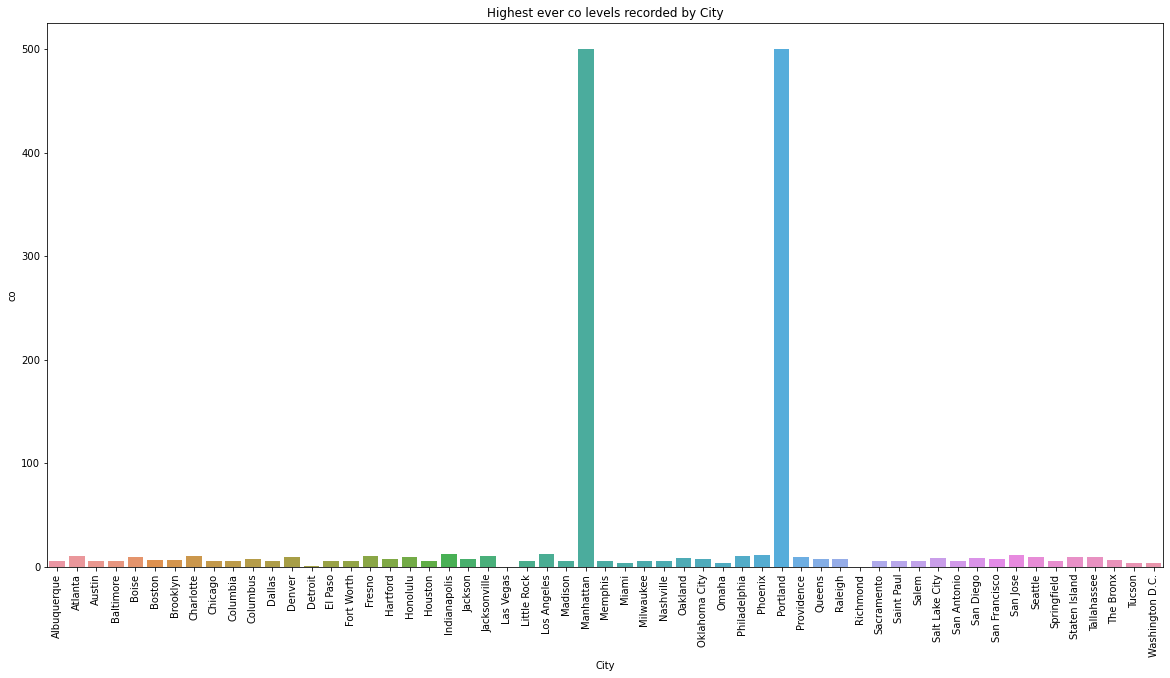

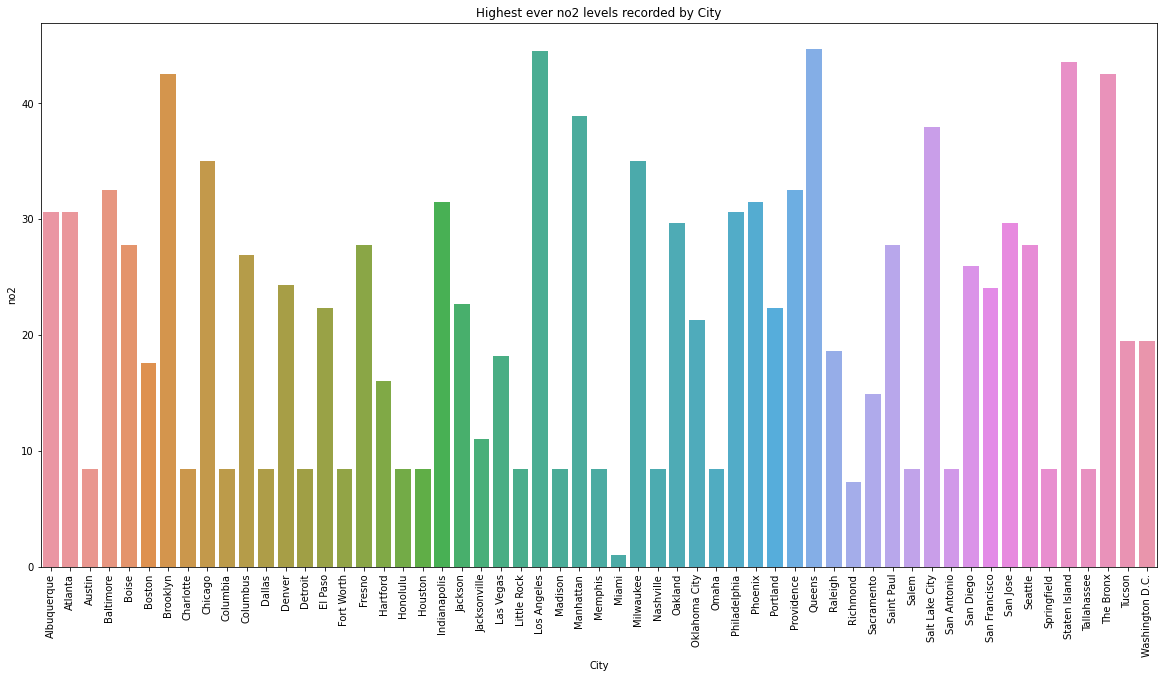

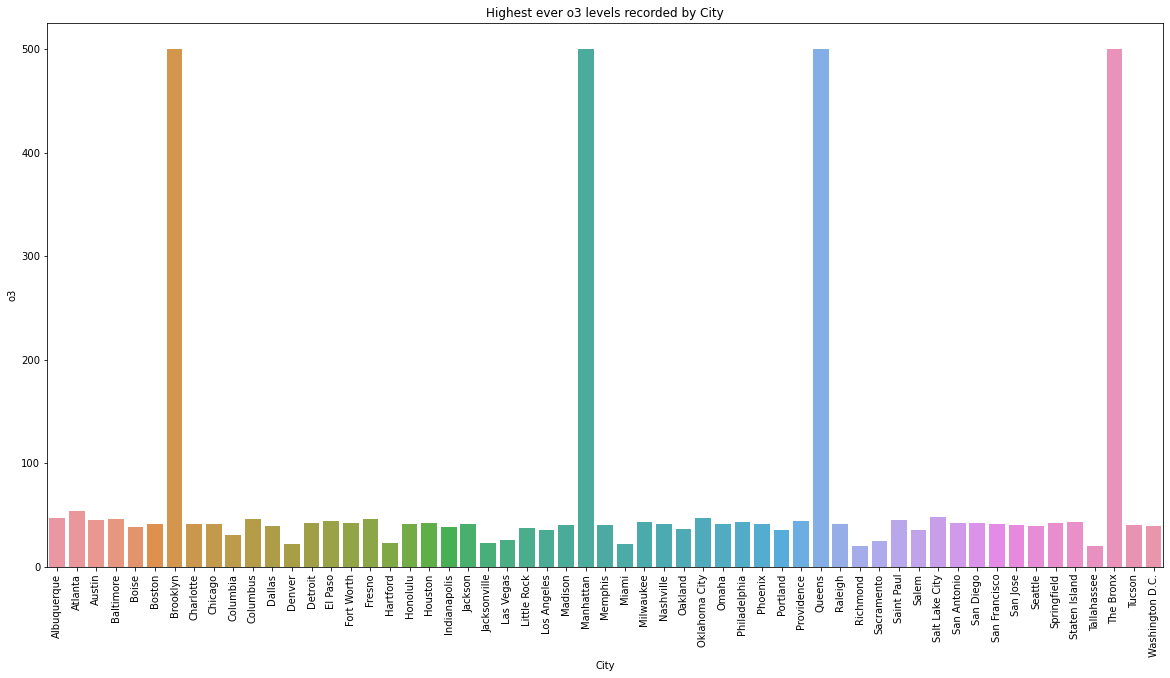

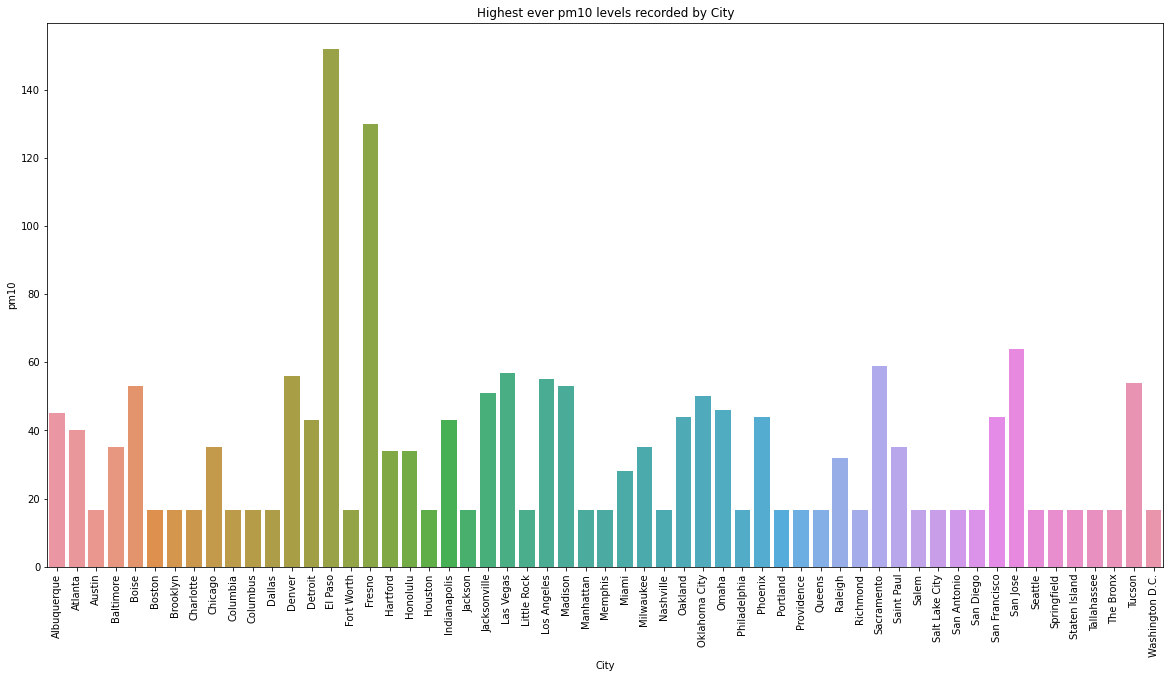

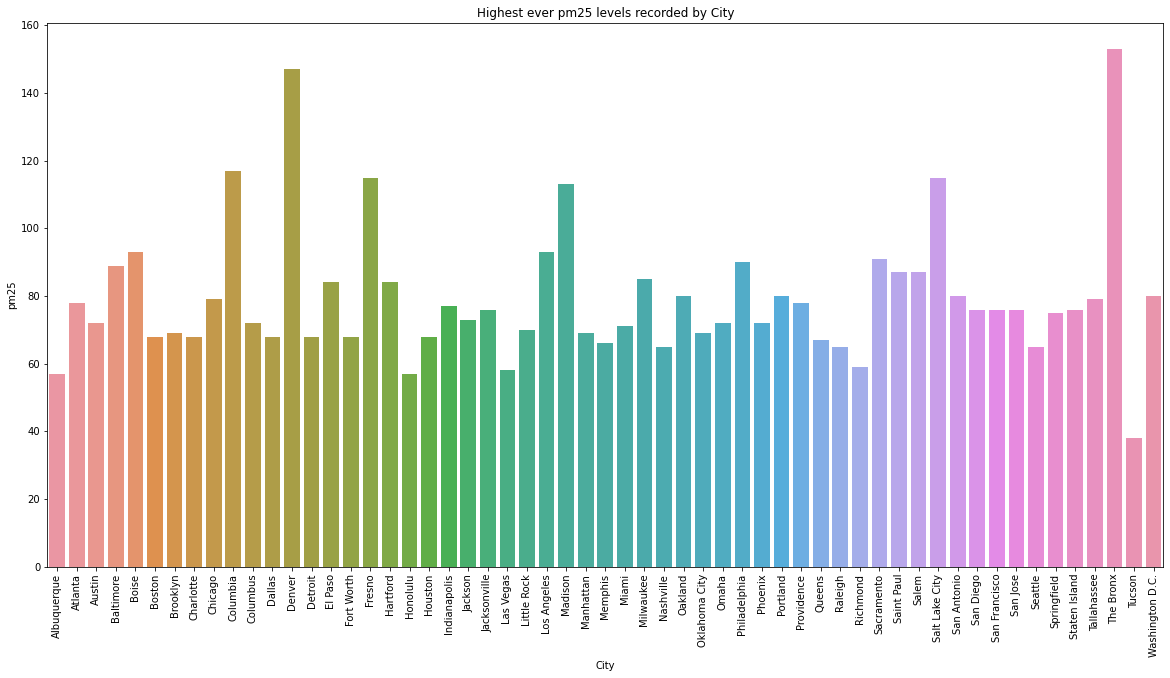

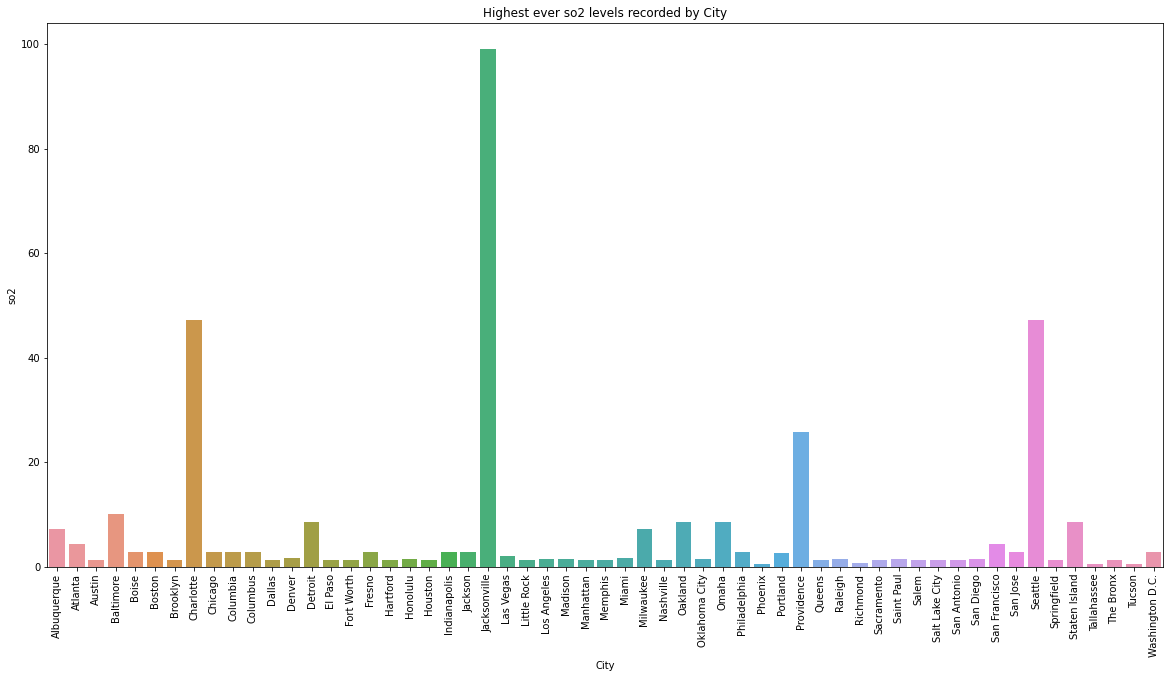

In [75]:
highest_levels_recorded("co")
highest_levels_recorded("no2")
highest_levels_recorded("o3")
highest_levels_recorded("pm10")
highest_levels_recorded("pm25")
highest_levels_recorded("so2")

In [76]:
# Since our USA filtered data set doesn't have AQI (air quality index), we had to calculate it.
# Luckily, there is a python package that does the calculation called python-aqi: https://pypi.org/project/python-aqi/
# This below command installs the package
!pip install python-aqi

In [77]:
# Create a python function that takes necessary pollutant values and invoke the python-aqi package to perform AQI calculation
# and return the value for each row. Here, we are considering pm25, pm10, no2 and so2. As per AQI calculation requirement, 
# we should have at least either pm25 or pm10 and two other pollutant attributes since not all pollutants are always recorded.

def getaqi(pm25, pm10, no2, so2):
    #print(pm25, pm10, no2, so2)
    myaqi = aqi.to_aqi([
        (aqi.POLLUTANT_PM25, pm25),
        (aqi.POLLUTANT_PM10, pm10),
        (aqi.POLLUTANT_NO2_1H, no2),
        (aqi.POLLUTANT_SO2_1H, so2)
    ])
    #print(myaqi)
    return myaqi

In [78]:
# Because for one of the rows pm25 is 507, which is more than 500.4 set in python-aqi library

# Set min values for pm25, pm10, no2 ans so2 as defined in https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['pm25'] < 0, 'pm25'] = 0
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['pm10'] < 0, 'pm10'] = 0
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['no2'] < 0, 'no2'] = 0
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['so2'] < 0, 'so2'] = 0

# Set max values for pm25, pm10, no2 ans so2 as defined in https://github.com/hrbonz/python-aqi/blob/master/aqi/algos/epa.py
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['pm25'] > 500.4, 'pm25'] = 500.4
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['pm10'] > 604, 'pm10'] = 604
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['no2'] > 2049, 'no2'] = 2049
df_2019_USA_FINAL.loc[df_2019_USA_FINAL['so2'] > 1004, 'so2'] = 1004


In [79]:
# Apply recursive lambda to call the above AQI function for each row to populate AQI value
df_2019_USA_FINAL["aqi"] = df_2019_USA_FINAL.apply(lambda row: getaqi(row['pm25'],
                                                                     row['pm10'],
                                                                     row['no2'],
                                                                     row['so2']), axis = 1)

In [80]:
# The above calls returns AQI value as an object but we need to conver this to numeric for further analysis
df_2019_USA_FINAL[['aqi']] = df_2019_USA_FINAL[['aqi']].apply(pd.to_numeric)

In [81]:
# Perform sorting by Date, City, Country
df_2019_USA_FINAL.sort_values(by=['Date', 'City', 'Country'], ascending=False)
df_2019_USA_FINAL.head(5)

Specie,Date,Country,City,co,no2,o3,pm10,pm25,so2,aqi
0,2018-12-31,US,Albuquerque,3.000000,16.700000,16.8,21.000000,40.0,1.500000,112.0
1,2018-12-31,US,Atlanta,1.800000,2.800000,15.2,12.000000,27.0,1.364257,82.0
2,2018-12-31,US,Austin,5.713845,8.420395,4.0,16.576044,21.0,1.254280,70.0
3,2018-12-31,US,Baltimore,5.713845,13.000000,12.8,21.000000,50.0,1.964286,137.0
4,2018-12-31,US,Boise,4.500000,10.080741,24.9,7.000000,9.0,0.800000,38.0


In [82]:
df_2019_USA_FINAL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21468 entries, 0 to 5547
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     21468 non-null  object 
 1   Country  21468 non-null  object 
 2   City     21468 non-null  object 
 3   co       21468 non-null  float64
 4   no2      21468 non-null  float64
 5   o3       21468 non-null  float64
 6   pm10     21468 non-null  float64
 7   pm25     21468 non-null  float64
 8   so2      21468 non-null  float64
 9   aqi      21468 non-null  float64
dtypes: float64(7), object(3)
memory usage: 1.8+ MB


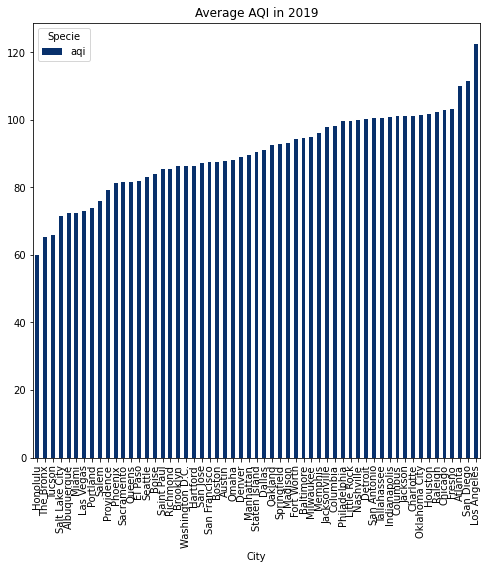

In [83]:
# Just a fun plot to see which city in USA is most polluted based on AQI value. Honolulu is healthy but LA is very bad
df_2019_USA_FINAL[['City','aqi']].groupby('City').mean().sort_values('aqi').plot(kind='bar',cmap='Blues_r',figsize=(8,8))
plt.title('Average AQI in 2019');

In [84]:
# Write the ML ready file to a CSV
df_2019_USA_FINAL.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_2019.csv', index=False)

In [85]:
#Change the date column format from object to date
df_2019_USA_FINAL['Date'] = pd.to_datetime(df_2019_USA_FINAL['Date'])

#Split the date column in to day, moth and year for ML
df_2019_USA_FINAL['Year']= df_2019_USA_FINAL['Date'].dt.year
df_2019_USA_FINAL['Month']= df_2019_USA_FINAL['Date'].dt.month
df_2019_USA_FINAL['Day']= df_2019_USA_FINAL['Date'].dt.day
df_2019_USA_FINAL.drop('Date',1)

# Drop the date column
df_final = df_2019_USA_FINAL.drop('Date',1)
rearranged_cols = ['Year','Month','Day','Country','City','co','no2','o3','pm10','pm25','aqi']
df_final = df_2019_USA_FINAL [rearranged_cols]
df_final.head(5)

/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_13045/417782863.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_2019_USA_FINAL.drop('Date',1)
/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_13045/417782863.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_final = df_2019_USA_FINAL.drop('Date',1)


Specie,Year,Month,Day,Country,City,co,no2,o3,pm10,pm25,aqi
0,2018,12,31,US,Albuquerque,3.000000,16.700000,16.8,21.000000,40.0,112.0
1,2018,12,31,US,Atlanta,1.800000,2.800000,15.2,12.000000,27.0,82.0
2,2018,12,31,US,Austin,5.713845,8.420395,4.0,16.576044,21.0,70.0
3,2018,12,31,US,Baltimore,5.713845,13.000000,12.8,21.000000,50.0,137.0
4,2018,12,31,US,Boise,4.500000,10.080741,24.9,7.000000,9.0,38.0


In [86]:
# Write the ML ready file to a CSV
df_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2019.csv', index=False)

In [87]:
from sklearn.preprocessing import LabelEncoder

# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
df_final['Country_Cat'] = labelencoder.fit_transform(df_final['Country'])
df_final['City_Cat'] = labelencoder.fit_transform(df_final['City'])
df_final = df_final.drop(['Country','City'], axis=1)
df_final.head(5)
rearranged_cols = ['Year','Month','Day','Country_Cat','City_Cat','co','no2','o3','pm10','pm25','aqi']
df_final = df_final [rearranged_cols]
df_final.head(5)

/var/folders/dr/dd4yfyn51lxdhh0dqg_f3dvh0000gq/T/ipykernel_13045/3044757240.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Country_Cat'] = labelencoder.fit_transform(df_final['Country'])


Specie,Year,Month,Day,Country_Cat,City_Cat,co,no2,o3,pm10,pm25,aqi
0,2018,12,31,0,0,3.000000,16.700000,16.8,21.000000,40.0,112.0
1,2018,12,31,0,1,1.800000,2.800000,15.2,12.000000,27.0,82.0
2,2018,12,31,0,2,5.713845,8.420395,4.0,16.576044,21.0,70.0
3,2018,12,31,0,3,5.713845,13.000000,12.8,21.000000,50.0,137.0
4,2018,12,31,0,4,4.500000,10.080741,24.9,7.000000,9.0,38.0


In [88]:
# Write the ML ready file to a CSV with encoded values for Country and City
df_final.to_csv('/Users/nkichili/Desktop/Synopsys/aqi_for_ml_2019_country_city_encoded.csv', index=False)

In [89]:
# Data Processing for ML
# Assign the first 9 columns to the X variable
X = df_final.drop(['aqi'], axis=1)

# Assign the last column, aqi, to the Y variable
y = df_final.iloc[:,-1]

In [90]:
# Data Splitting for ML
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [91]:
# Build the linear Regression Model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [92]:
# Apply ML model to make predictions on the training set and test set
y_lr_train_pred = lr.predict(X_train)
y_lr_test_pred = lr.predict(X_test)

In [93]:
# Calculate the performance metrics to determine the model performance
from sklearn.metrics import mean_squared_error, r2_score
lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
lr_train_r2 = r2_score(y_train, y_lr_train_pred)
lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
lr_test_r2 = r2_score(y_test, y_lr_test_pred)

In [94]:
print(lr_train_mse)
print(lr_test_mse)
print(lr_train_r2)
print(lr_test_r2)

19.426113343010332
19.558337822730557
0.9790034970875974
0.9791974584654639


In [48]:
# save the model
filename = 'aqi_model.sav'
joblib.dump(lr, filename)

['aqi_model.sav']